In [1]:
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv", delimiter = ";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
df.drop(["duration"], axis=1, inplace=True)

In [5]:
df[["y"]]=df[["y"]].apply(LabelEncoder().fit_transform)

In [6]:
df_dummies = pd.get_dummies(df)
df_dummies

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [7]:
df_dummies["Prediction"] = df_dummies["y"]
df_dummies.drop(["y"], axis=1, inplace=True)

In [8]:
df_dummies["Prediction"].value_counts()

0    36548
1     4640
Name: Prediction, dtype: int64

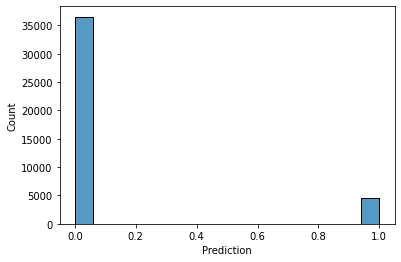

In [9]:
sns.histplot(df_dummies["Prediction"], kde=False)

In [10]:
print("Imblance: %.2f" % (4640/(4640+36548)))

Imblance: 0.11


In [11]:
X = df_dummies.iloc[:, 0:-1]
print(X)
y = df_dummies.iloc[:, -1]
print(y)

       age  campaign  ...  poutcome_nonexistent  poutcome_success
0       56         1  ...                     1                 0
1       57         1  ...                     1                 0
2       37         1  ...                     1                 0
3       40         1  ...                     1                 0
4       56         1  ...                     1                 0
...    ...       ...  ...                   ...               ...
41183   73         1  ...                     1                 0
41184   46         1  ...                     1                 0
41185   56         2  ...                     1                 0
41186   44         1  ...                     1                 0
41187   74         3  ...                     0                 0

[41188 rows x 62 columns]
0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: Prediction, Length: 41188, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 50, stratify = y)

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3)
scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring=make_scorer(acc))
print("RandomForest accuracy: %.2f" % (scores.mean()))

RandomForest accuracy: 0.90


In [14]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_scores = cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring=make_scorer(acc))
print("Dummy accuracy: %.2f" % (dummy_scores.mean()))

Dummy accuracy: 0.80


In [15]:
param_grid = {'max_depth': np.arange(3,9),
        'n_estimators': np.arange(100,161,10)}
rf_cv = GridSearchCV(rf_clf, param_grid, cv=10)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [16]:
print(rf_cv.best_score_)
print(rf_cv.best_params_)

0.9001517450682852
{'max_depth': 8, 'n_estimators': 100}


In [17]:
pred_rf_cv = rf_cv.predict(X_test)

In [18]:
print(confusion_matrix(y_test, pred_rf_cv))
print(classification_report(y_test, pred_rf_cv))

[[7215   95]
 [ 721  207]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.22      0.34       928

    accuracy                           0.90      8238
   macro avg       0.80      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



In [19]:
rf_clf.fit(X_train, y_train)
features_list = X_train.columns.values
feature_importance = rf_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

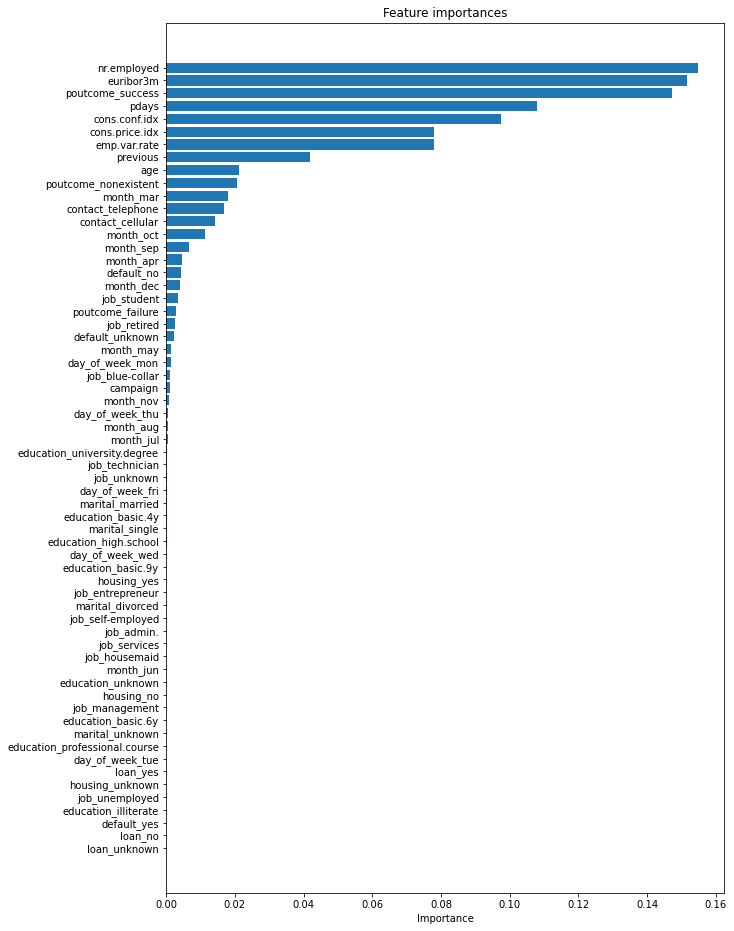

In [20]:
plt.figure(figsize=(10,16))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [21]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [26]:
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=6)
scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring="f1")
scores.mean()

0.2830584314568364

In [27]:
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=6)
scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring="f1")
scores.mean()

0.2834107402165323

In [28]:
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=6, random_state = 60)
scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring="f1")
scores.mean()

0.28289199865770376

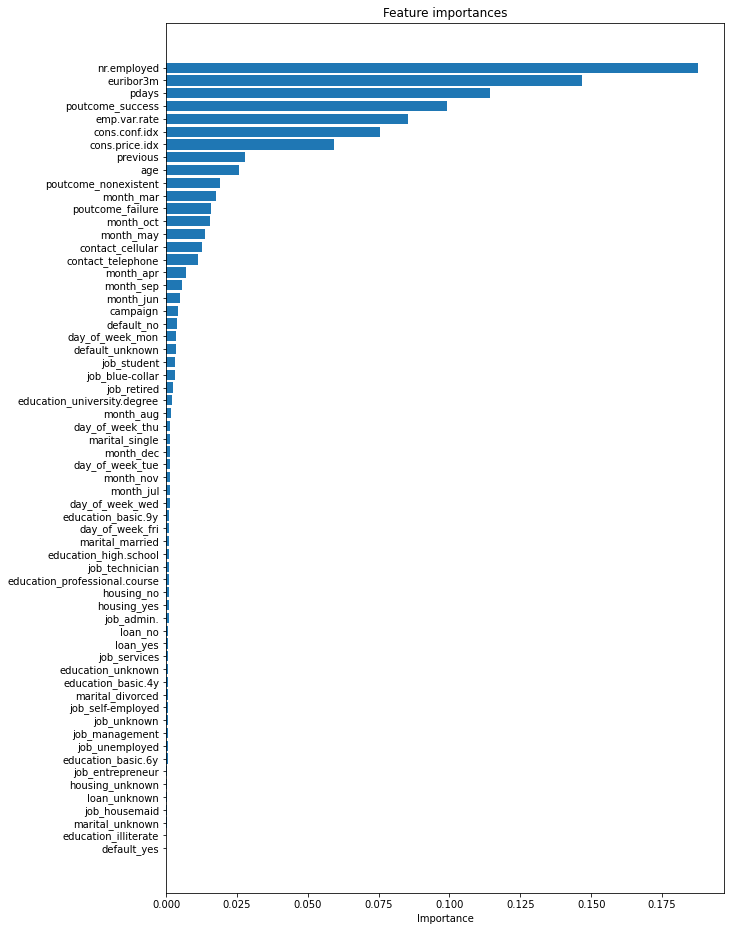

In [29]:
rf_clf = RandomForestClassifier(n_estimators=750, max_depth=6, random_state=60)
rf_clf.fit(X_train, y_train)
features_list = X_train.columns.values
feature_importance = rf_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10,16))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()